In [211]:
# Code to demonstrate the SFDA approach on the mednist data
import numpy as np
from models.classifier import  Encoder, Regressor
from datasets.numpy_dataset import numpy_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from utils import Args, EarlyStopping_split_models
import sys
import json
import torch.optim as optim
from torch.autograd import Variable
from losses.bhattacharya import bhattachayra_GMM
from GMM.gmm_EM import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from torch.autograd import Variable
from sklearn.metrics import accuracy_score


Assume the source model has already been trained. First will demonstrate fitting the GMM to create the components and then finetuning the model on the target site

In [212]:
n_components = 2
site = 2
batchsize = 500

In [213]:
emb = np.load('pretrained_model/source_1_X_1_test_embeddings.npy').squeeze()
print(emb.shape)
emb = emb.reshape(-1, 32, 1)
feat = torch.from_numpy(emb)
model = GaussianMixture(32, n_components, 1, covariance_type="diag", init_params="random")
model.fit(feat, n_iter=20)
ref_pi = model.pi.detach().numpy().reshape(-1, n_components)
ref_var = model.var.detach().numpy().reshape(-1, n_components)
ref_mu = model.mu.detach().numpy().reshape(-1, n_components)
print(pi.shape)
print(var.shape)
print(mu.shape)

(2400, 32)
(32, 2)
(32, 2)
(32, 2)


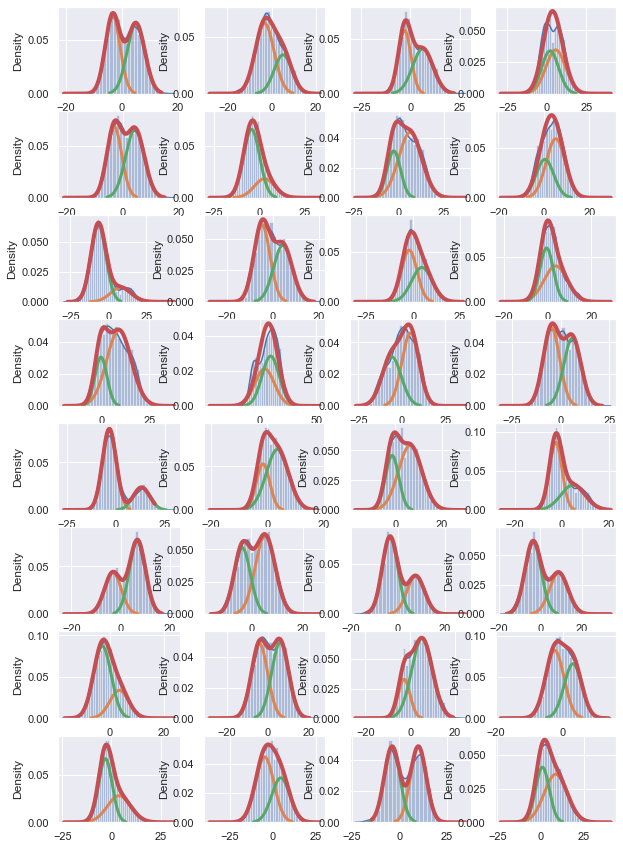

In [214]:
# Plotting only works for 2 components
def plot_guassian_weight(mean, std, weight, vmin=None, vmax=None, c=None):
    if vmin == None:
        vmin = mean - 3 * std
    if vmax == None:
        vmax = mean + 3 * std
    x_data = np.arange(vmin, vmax, 0.001)
    y_data = stats.norm.pdf(x_data, mean, std) * weight
    if c:
        plt.plot(x_data, y_data, c=c, linewidth=3)
    else:
        plt.plot(x_data, y_data, linewidth=3)
    return
def plot_guassian_weight_2(mean1, std1, weight1, mean2, std2, weight2, vmin=None, vmax=None, c=None):
    mean = (mean1 + mean2)/2
    if vmin == None:
        vmin = mean1 - 3 * (std1+std2)
    if vmax == None:
        vmax = mean1 + 3 * (std1+std2)
        
    x_data = np.arange(vmin, vmax, 0.001)
    y_data = stats.norm.pdf(x_data, mean1, std1) * weight1
    
    y_data2 = stats.norm.pdf(x_data, mean2, std2) * weight2
    
    y_data = y_data + y_data2

    if c:
        plt.plot(x_data, y_data, c=c, linewidth=4)
    else:
        plt.plot(x_data, y_data, linewidth=4)
    return

plt.figure(figsize=(10,15))
for i in range(0, 32):
    plt.subplot(8,4,i+1)
    sns.distplot(emb[:,i])
    plot_guassian_weight(ref_mu[i,0], np.sqrt(ref_var[i,0]), ref_pi[i,0])
    plot_guassian_weight(ref_mu[i,1], np.sqrt(ref_var[i,1]), ref_pi[i,1])
    plot_guassian_weight_2(ref_mu[i,0], np.sqrt(ref_var[i,0]), ref_pi[i,0], ref_mu[i,1], np.sqrt(ref_var[i,1]), ref_pi[i,1])

Now we finetune the encoder on the data for the target site

In [215]:
LOAD_PATH_ENCODER = 'pretrained_model/weight_encoder_site_1_checkpoint'
LOAD_PATH_REGRESSOR = 'pretrained_model/weight_regressor_site_1_checkpoint'

CHK_PATH_ENCODER = 'weight_encoder_finetune_site2_checkpoint'
CHK_PATH_REGRESSOR = 'weight_regressor_finetune_site2_checkpoint'

# Create an args class
args = Args()
args.channels_first = True
args.epochs = 500
args.batch_size = batchsize
args.patience = 10
args.train_val_prop = 0.75
args.learning_rate = 1e-6

In [216]:
encoder = Encoder()
regressor = Regressor()
if LOAD_PATH_ENCODER:
   print('Loading Weights')
   encoder_dict = encoder.state_dict()
   pretrained_dict = torch.load(LOAD_PATH_ENCODER)
   pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in encoder_dict}
   print('weights loaded unet = ', len(pretrained_dict), '/', len(encoder_dict))
   encoder.load_state_dict(torch.load(LOAD_PATH_ENCODER))
if LOAD_PATH_REGRESSOR:
   print('Loading Weights')
   encoder_dict = regressor.state_dict()
   pretrained_dict = torch.load(LOAD_PATH_REGRESSOR)
   pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in encoder_dict}
   print('weights loaded segmenter = ', len(pretrained_dict), '/', len(encoder_dict))
   regressor.load_state_dict(torch.load(LOAD_PATH_REGRESSOR))
print('Freeze regressor')
for param in regressor.parameters():
    param.requires_grad = False
models = [encoder, regressor]

Loading Weights
weights loaded unet =  30 / 30
Loading Weights
weights loaded segmenter =  4 / 4
Freeze regressor


Lets test the model performance on the test data before we finetune the model

In [217]:
X_test = np.load('data/X_' + str(site) + '_test.npy')
y_test = np.load('data/y_' + str(site) + '_test.npy')
X_test = np.reshape(X_test, (-1, 1, 28, 28))
datatset = numpy_dataset(X_test, y_test)
dataloader = DataLoader(datatset, batch_size=args.batch_size, shuffle=False, num_workers=0)

class_pred = []
class_true = []
encoder.eval()
regressor.eval()
with torch.no_grad():
    for data, target in dataloader:
        data, target = Variable(data), Variable(target)
        if list(data.size())[0] == args.batch_size:
                class_true.append(target.detach().cpu().numpy())
                x = encoder(data)
                pred = regressor(x)
                pred = np.argmax(pred.detach().numpy(), axis=1)
                class_pred.append(pred.reshape(-1))
class_pred = np.array(class_pred).reshape(-1)
class_true = np.array(class_true).reshape(-1)
accuracy = accuracy_score(class_pred, class_true) * 100
print('Accuracy = ', accuracy)

Accuracy =  70.35


And now lets finetune the model without any training labels

In [218]:
X_total = np.load('data/X_' + str(site) + '_train.npy')
proportion = int(args.train_val_prop * len(X_total))
X_total_train = X_total[:proportion]
X_total_val = X_total[proportion:]
X_total_train, X_total_val = np.reshape(X_total_train, (-1, 1, 28, 28)), np.reshape(X_total_val, (-1, 1, 28, 28))

print('Training: ',X_total_train.shape, flush=True)
print('Validation: ', X_total_val.shape, flush=True)

total_train_dataset = numpy_dataset(X_total_train, X_total_train)
total_val_dataset = numpy_dataset(X_total_val, X_total_val)

total_train_dataloader = DataLoader(total_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
total_val_dataloader = DataLoader(total_val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)

bhatt_criterion = bhattachayra_GMM(n_components, ref_mu, ref_var, ref_pi)
optimizer = optim.AdamW(list(encoder.parameters()), lr=args.learning_rate)
# Initalise the early stopping
early_stopping = EarlyStopping_split_models(args.patience, verbose=False)
loss_store = []

Training:  (4500, 1, 28, 28)
Validation:  (1500, 1, 28, 28)


In [219]:
def train_bhatt_GMM(args, models, train_loader, optimizer, criterion, epoch):
    [encoder, _] = models
    
    bhatt_loss = 0
    
    encoder.train()
    gmm_model = GaussianMixture(32, n_components, 1, covariance_type="diag", init_params="random")
    batches = 0
    for batch_idx, (total_data, _) in enumerate(train_loader):
        total_data =  Variable(total_data)
        
        if list(total_data.size())[0] == args.batch_size :
            batches += 1
            # First update the encoder and regressor
            optimizer.zero_grad()
            features = encoder(total_data)
            features = features.view(-1, 32, 1)

            gmm_model.fit(features, n_iter=20)
                        
            loss = criterion(gmm_model.mu, torch.sqrt(gmm_model.var), gmm_model.pi)
            loss.backward()
            optimizer.step()
            
            bhatt_loss += loss.detach().cpu().numpy()

            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(total_data), len(train_loader.dataset),
                           100. * (batch_idx+1) / len(train_loader), loss.item()), flush=True)

    av_bhatt = bhatt_loss / batches 
    print('Training set: Average Bhatt: {:.4f}'.format(av_bhatt,  flush=True))

    return  av_bhatt

def val_normal_bhatt(args, models, val_loader, criterion):
    [encoder, regressor] = models
    
    encoder.eval()
    regressor.eval()
    gmm_model = GaussianMixture(32, n_components, 1, covariance_type="diag", init_params="random")

    total_loss = 0
    batches = 0
    with torch.no_grad():
        for _,  (total_data, _) in enumerate( val_loader):
            total_data = Variable(total_data)

            if list(total_data.size())[0] == args.batch_size:
                batches += 1
                features = encoder(total_data)
                features = features.view(-1, 32, 1)
                gmm_model.fit(features, n_iter=20)
                loss = criterion(gmm_model.mu, torch.sqrt(gmm_model.var), gmm_model.pi)
                total_loss  += loss.detach().cpu().numpy()

    av_loss = total_loss / batches

    print('\nValidation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('\n') 
    return av_loss

In [220]:
epoch_reached = 1
for epoch in range(epoch_reached, args.epochs+1):   
    train_loss = train_bhatt_GMM(args, models, total_train_dataloader, optimizer, bhatt_criterion, epoch)
    val_loss = val_normal_bhatt(args, models, total_val_dataloader, bhatt_criterion)
    # Decide whether the model should stop training or not
    early_stopping(val_loss, models, epoch, optimizer, train_loss, [CHK_PATH_ENCODER, CHK_PATH_REGRESSOR])
    if early_stopping.early_stop:
        print('Patience Reached - Early Stopping Activated')
        break
    torch.cuda.empty_cache()  # Clear memory cache

Train Epoch: 1 [500/4500 (11%)]	Loss: 0.225550
Training set: Average Bhatt: 0.2289

Validation set: Average loss: 0.2446


Train Epoch: 2 [500/4500 (11%)]	Loss: 0.235070
Training set: Average Bhatt: 0.2290

Validation set: Average loss: 0.2375


Train Epoch: 3 [500/4500 (11%)]	Loss: 0.241620
Training set: Average Bhatt: 0.2302

Validation set: Average loss: 0.2321


Train Epoch: 4 [500/4500 (11%)]	Loss: 0.219886
Training set: Average Bhatt: 0.2319

Validation set: Average loss: 0.2272


Train Epoch: 5 [500/4500 (11%)]	Loss: 0.223303
Training set: Average Bhatt: 0.2282

Validation set: Average loss: 0.2291


Early Stopping Counter:  1 / 10
Train Epoch: 6 [500/4500 (11%)]	Loss: 0.233007
Training set: Average Bhatt: 0.2273

Validation set: Average loss: 0.2288


Early Stopping Counter:  2 / 10
Train Epoch: 7 [500/4500 (11%)]	Loss: 0.237232
Training set: Average Bhatt: 0.2331

Validation set: Average loss: 0.2358


Early Stopping Counter:  3 / 10
Train Epoch: 8 [500/4500 (11%)]	Loss: 0.228

In [221]:
X_test = np.load('data/X_' + str(site) + '_test.npy')
y_test = np.load('data/y_' + str(site) + '_test.npy')
X_test = np.reshape(X_test, (-1, 1, 28, 28))
datatset = numpy_dataset(X_test, y_test)
dataloader = DataLoader(datatset, batch_size=args.batch_size, shuffle=False, num_workers=0)

class_pred = []
class_true = []
encoder.eval()
regressor.eval()
with torch.no_grad():
    for data, target in dataloader:
        data, target = Variable(data), Variable(target)
        if list(data.size())[0] == args.batch_size:
                class_true.append(target.detach().cpu().numpy())
                x = encoder(data)
                pred = regressor(x)
                pred = np.argmax(pred.detach().numpy(), axis=1)
                class_pred.append(pred.reshape(-1))
class_pred = np.array(class_pred).reshape(-1)
class_true = np.array(class_true).reshape(-1)
accuracy = accuracy_score(class_pred, class_true) * 100
print('Accuracy = ', accuracy)

Accuracy =  88.0
